## Libraries importeren

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random
import cv2
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

#### Set seed

In [2]:
torch.manual_seed(42)
np.random.seed(42)

## Train en test data samenstellen

#### Dataset inladen en inzien
Voordat ik de data volledig ga transformeren, wil ik eerst het gemiddelde en de standaardafwijking weten voor de normalisatie. Daarnaast wil ik ook weten wat de grote van de afbeelding is qua pixels en het kanaal (grijstinten of rgb).

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

alle_afbeeldingen = torch.cat([image.unsqueeze(0) 
                               for image, _ in train_data], dim=0)

print(f"Gemiddelde: {alle_afbeeldingen.mean().item():.4f}, Standaardafwijking: {alle_afbeeldingen.std().item():.4f}")

Gemiddelde: 0.1307, Standaardafwijking: 0.3081


#### Data transformeren

##### Custom functies maken

In [4]:
def random_background(img):
    achtergrond_kleur = random.randint(190, 240)
    afbeelding_np = np.array(img)
    mask = afbeelding_np < 255
    
    achtergrond = np.full_like(afbeelding_np, achtergrond_kleur)
    afbeelding_np = np.where(mask, afbeelding_np, achtergrond)
    return Image.fromarray(afbeelding_np.astype(np.uint8))

def custom_erasing(img, strength):
    afbeelding_np = np.array(img)
    mask = afbeelding_np < 255

    coördinaten = np.argwhere(mask)
    coördinaten_gesorteerd = coördinaten[np.lexsort((coördinaten[:, 1], coördinaten[:, 0]))]

    aantal_te_verwijderen = int(len(coördinaten_gesorteerd) * (strength ** 2))

    if aantal_te_verwijderen == 0:
        return img
    
    if np.random.rand() < 0.5:
        geselecteerde = coördinaten_gesorteerd[:aantal_te_verwijderen]
    else:
        geselecteerde = coördinaten_gesorteerd[-aantal_te_verwijderen:]
        
    for y, x in geselecteerde:
        afbeelding_np[y, x] = 255

    return Image.fromarray(afbeelding_np.astype(np.uint8))

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28), interpolation=transforms.InterpolationMode.LANCZOS), #Juiste afmetingen invoeren 
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)), #Willekeurige onregelmatigheden en schaal
    transforms.RandomInvert(p=1),
    transforms.RandomApply([transforms.Lambda(lambda img: custom_erasing(img, strength=0.28))], p=0.3), #Verwijder willekeurige clusters aan pixels
    transforms.RandomApply([transforms.Lambda(lambda img: random_background(img))], p=0.3), #Introduceert random achtergronden ipv alleen maar puur wit
    transforms.RandomRotation(10),  #Willekeurige rotaties tot 10 graden
    transforms.ColorJitter(contrast=0.6, brightness=0.4),
    transforms.GaussianBlur(3, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) #Normalisatie op basis van het gem en standaardafwijking
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


#### Train data inspecteren

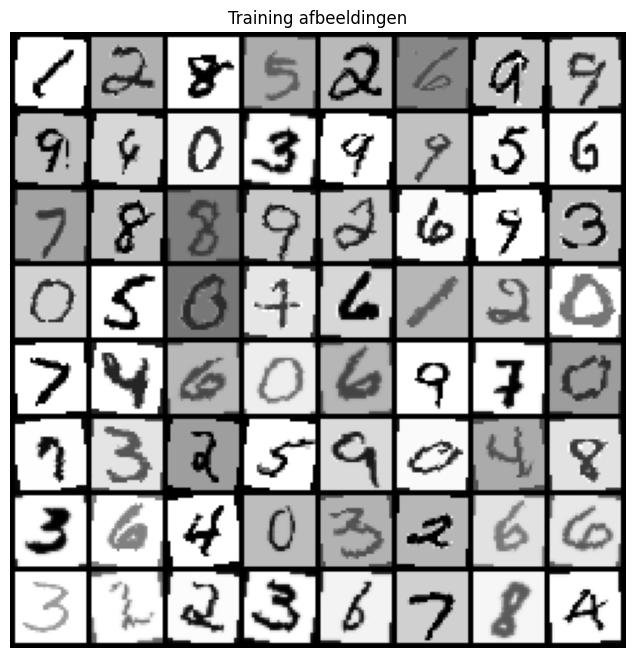

torch.Size([1, 28, 28])


In [6]:
eerste_batch = next(iter(train_loader))
images, labels = eerste_batch

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training afbeeldingen")

grid_afbeeldingen = np.transpose(vutils.make_grid(images[:100], padding=2, normalize=True), (1, 2, 0))

plt.imshow(grid_afbeeldingen)
plt.show()

#Formaat checken
image, label = test_data[0]
print(image.shape)

## Architectuur van CNN bouwen

In [7]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(256, 10)
)

#### Check voor GPU
I.v.m. dat het model zwaar kan zijn, check ik eerst ff of het huidige apparaat een GPU heeft. Dit kan het trainen een stuk versneller namelijk.

In [8]:
component = torch.device("cuda" if torch.cuda.is_available()
                         else "cpu")
model = model.to(component)
print(f"Model runt op {component}")

Model runt op cpu


## Model trainen

In [9]:
optimalisator = optim.Adam(model.parameters(), lr=0.0001)
criterium = nn.CrossEntropyLoss()

In [10]:
model.train()

epochs = 10
for epoch in range(epochs):
    totale_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(component), labels.to(component) #Runt het model op het geschikte component
        
        optimalisator.zero_grad()
        output = model(images)
        loss = criterium(output, labels)
        loss.backward()
        optimalisator.step()
        totale_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {totale_loss / len(train_loader)}")

torch.save(model.state_dict(), "Getrainde_modellen/CNN_Model_gewichten.pth")


Epoch 1, Loss: 0.44334971537785745
Epoch 2, Loss: 0.12234060834449872
Epoch 3, Loss: 0.08834651168406026
Epoch 4, Loss: 0.07422451698742528
Epoch 5, Loss: 0.0644153953775136
Epoch 6, Loss: 0.056795894085908176
Epoch 7, Loss: 0.053218951708436615
Epoch 8, Loss: 0.049471319045698736
Epoch 9, Loss: 0.04523737161759851
Epoch 10, Loss: 0.04330916892213902


#### Laad getrainde model indien nodig (voor apparaten zonder cuda bijvoorbeeld)

In [16]:
model.load_state_dict(torch.load("Getrainde_modellen/CNN_Model_gewichten.pth", 
                                 map_location=torch.device(component)))


<All keys matched successfully>

## Evaluatie van model

In [17]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    for images, labels in test_loader:
        images, labels = images.to(component), labels.to(component)
        test_output = model(images)
        _, predicted = torch.max(test_output, 1)
        correct_voorspeld += (predicted == labels).sum().item()
        totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Voorspelde labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Accuratie na training: 98.97%


#### Klassen en functies maken voor nieuwe data inzien en verwerken

In [18]:
## Transform functie maken
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Handschrift dataset klas maken
class HandSchriftDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths= []
        self.labels = []

        for i in os.listdir(root_dir):
            path = f"{root_dir}/{i}" #Stelt het pad samen 
            cijfer = i[6:7] #Pakt het cijfer na "Nummer"
    
            self.image_paths.append(path)
            self.labels.append(int(cijfer))
            
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        #Transformeren en binaliseren van afbeelding
        afbeelding = Image.open(image_path).convert("L")
        if self.transform: #Als transform parameter meegegeven is
            afbeelding = self.transform(afbeelding)
        
        return afbeelding, label

#### Data transformeren en inspecteren

torch.Size([1, 28, 28])


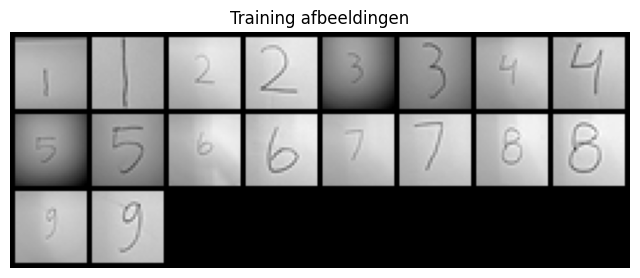

In [19]:
test_dataset = HandSchriftDataset("Afbeeldingen", transform=transform)
afbeeldingen = []
for i in range(0, len(test_dataset)):
    image, label = test_dataset[i]
    afbeeldingen.append(image)
print(image.shape)

afbeeldingen = torch.stack(afbeeldingen)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("Training afbeeldingen")

grid_afbeeldingen = np.transpose(vutils.make_grid(afbeeldingen, padding=2, normalize=True), (1, 2, 0))

plt.imshow(grid_afbeeldingen)
plt.show()


#### Nieuwe data introduceren in CNN

In [20]:
model.eval()
correct_voorspeld = 0
totaal_voorspeld = 0
with torch.no_grad():
    images = torch.stack([data[0] for data in test_dataset])
    labels = torch.tensor([data[1] for data in test_dataset], dtype=torch.long)

    images, labels = images.to(component), labels.to(component)
    test_output = model(images)
    _, predicted = torch.max(test_output, 1) 
    correct_voorspeld += (predicted == labels).sum().item()
    totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:20].tolist())  
print("Voorspelde labels:", predicted[:20].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")


Werkelijke labels: [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
Voorspelde labels: [1, 1, 1, 2, 1, 1, 1, 7, 1, 5, 1, 6, 1, 1, 5, 3, 1, 9]
Accuratie na training: 33.33%


## Live camera interface

In [ ]:
cam = cv2.VideoCapture(0)
if not cam.isOpened():
    print("Camera kan niet geopend worden.")
    exit()
    
interval = 0.5
laatste_tijd = 0

while(True):
    ret, frame = cam.read()
    
    huidige_tijd = time.perf_counter()
    
    if not ret:
        print("Frame kan niet ontvangen worden.")
        break
        
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_PIL = Image.fromarray(rgb_frame)
    
    input_tensor = transform(frame_PIL).unsqueeze(0)
    
    if huidige_tijd - laatste_tijd > interval: 
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        zekerheidsgraad, voorspelling = torch.max(probs, dim=1)
        
        print(f"Voorspelde nummer: {voorspelling.item()} - Zekerheidsgraad: {zekerheidsgraad.item() * 100:.2f}%")
        
        laatste_tijd = huidige_tijd
    
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) == ord('q'):
        break
    
cam.release()
cv2.destroyAllWindows()


Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.86%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.99%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.96%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.97%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.91%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 98.91%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.99%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.89%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 99.96%
Voorspelde nummer: tensor([4]) - Zekerheidsgraad: 20.68%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 90.90%
Voorspelde nummer: tensor([7]) - Zekerheidsgraad: 86.00%
Voorspelde nummer: tensor([5]) - Zekerheidsgraad: 52.46%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 92.20%
Voorspelde nummer: tensor([4]) - Zekerheidsgraad: 55.85%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 80.26%
Voorspelde nummer: tensor([9]) - Zekerheidsgraad: 95.82%
Voorspelde nummer: tensor([9]) 